# ARF generation in annuli

Fro galaxy clusters analysis, the flux loss in different annuli.

Using the latest XMM-SAS 18.0 (19 June 2019)

In [32]:
import os
import subprocess
import numpy as np
import sys

from astropy.io import fits

import logging

%matplotlib inline
import matplotlib.pylab as plt

In [22]:
def run_command(command,verbose=True):
    #
    # Execute a shell command with the stdout and stderr being redirected to a log file 
    #
    try:
        result = subprocess.run(command, shell=True,stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
        retcode=result.returncode
        if retcode < 0:
            if (verbose):
                print(f"Execution of {command} was terminated by signal", -retcode, file=sys.stderr)
            logging.warning("Execution of {} was terminated by signal: {} \n {}".format(command,-retcode,result.stdout.decode()))
        else:
            if (verbose):
                print(f"Execution of {command} returned", retcode, file=sys.stderr)
            logging.info("Execution of {} returned {}, \n {}".format(command,retcode,result.stdout.decode()))
    except OSError as e:
        print(f"Execution of {command} failed:", e, file=sys.stderr)
        logging.error("Execution of {} failed: {}".format(command,e))
    return retcode


In [23]:
#
# set up XMM-SAS
#
# the current one is 18.0 ==> /home/xcaldata/setsas_180.sh
# tests with XMM-SAS 16.1 for the arfgen
#!. /home/xcaldata/setsas_161.sh
#
sas_dir = "/sas/Linux/RHEL_6.9Workstation/64/sas18_0_0"
#sas_dir = "/sas/Linux/RHEL_6.9Workstation/64/sas16_1_0"
os.environ["SAS_DIR"]= sas_dir
os.environ["SAS_PATH"]=os.environ["SAS_DIR"]
os.environ["SAS_VERBOSITY"]="4"
os.environ["SAS_SUPPRESS_WARNING"]="1"
path = os.environ["PATH"]
os.environ["PATH"] = f"{sas_dir}/bin:{sas_dir}/binextra:{path}"
ld_path = os.environ["LD_LIBRARY_PATH"]
lib_path = f"{sas_dir}/lib:{sas_dir}/libextra:{sas_dir}/libsys:{ld_path}"
os.environ["LD_LIBRARY_PATH"] = lib_path
#
# check
#print ("PATH = ",os.environ["PATH"])
#print ("LF_LIBRARY_PATH = ",os.environ["LD_LIBRARY_PATH"])
#for ikey in os.environ.keys():
#    if ('SAS' in ikey):
#        print (ikey," = ",os.environ[ikey])
!sasversion

sasversion:- Executing (routine): sasversion  -w 1 -V 4
sasversion:- sasversion (sasversion-1.3)  [xmmsas_20190531_1155-18.0.0] started:  2019-06-19T10:33:57.000
sasversion:- XMM-Newton SAS release and build information:

SAS release: xmmsas_20190531_1155-18.0.0
Compiled on: Sun Jun  2 14:11:08 CEST 2019
Compiled by: sasbuild@sasbld01n.net4.lan
Platform   : RHEL6.8 64

SAS-related environment variables that are set:

SAS_DIR = /sas/Linux/RHEL_6.9Workstation/64/sas18_0_0
SAS_PATH = /sas/Linux/RHEL_6.9Workstation/64/sas18_0_0
SAS_CCFPATH = /ccf/pub
SAS_CCF = /lhome/ivaltchanov/XMM-clusters//A1795/0097820101/proc/ccf.cif
SAS_ODF = /lhome/ivaltchanov/XMM-clusters//A1795/0097820101

sasversion:- sasversion (sasversion-1.3)  [xmmsas_20190531_1155-18.0.0] ended:    2019-06-19T10:33:57.000


In [24]:
#
# set up the paths, the target and the OBS_ID
#
root_dir = "/lhome/ivaltchanov/XMM-clusters/"
target="A1795"
obsid="0097820101"
# the output processing will be saved to a folder proc_161
#pps="proc_161"
pps="proc"
odf_dir = f"{root_dir}/{target}/{obsid}"
#
if (not os.path.isdir(odf_dir)):
    print (f"{odf_dir} does not exist. Cannot continue.")
    raise FileNotFoundError
else:
    print (f"Found ODF folder: {odf_dir}.")
#
pps_dir = f"{root_dir}/{target}/{obsid}/{pps}"
if (not os.path.isdir(pps_dir)):
    print (f"{pps_dir} does not exist. Will create it.")
    os.mkdir(pps_dir)
else:
    print (f"Will use {pps_dir} for the products.")
#
# logging to file
#
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s %(levelname)s %(message)s',
                    filename=f'{pps_dir}/annuli_work.log',
                    filemode='w')
#
os.environ['SAS_ODF'] = odf_dir
os.environ['SAS_CCFPATH'] = '/ccf/pub'

Found ODF folder: /lhome/ivaltchanov/XMM-clusters//A1795/0097820101.
Will use /lhome/ivaltchanov/XMM-clusters//A1795/0097820101/proc for the products.


In [25]:
status = run_command('sasversion')
if (status != 0):
    raise Exception

Execution of sasversion returned 0


In [26]:
# **Step 1:** Assuming the ODF is already available in odf_dir, then run cifbuild
os.chdir(odf_dir)
#
# For tests with XMM-SAS v16.1, set the corretc analysis date
#
cif_file = f"{pps_dir}/ccf.cif"
comm = f"cifbuild calindexset={cif_file}"
status = run_command(comm)
if (status != 0):
    raise Exception
#
os.environ['SAS_CCF'] = cif_file

Execution of cifbuild calindexset=/lhome/ivaltchanov/XMM-clusters//A1795/0097820101/proc/ccf.cif returned 0


We have all necessary products for extracting spectra in annuli, just have to build the annuli:



In [27]:
regfile = f"{pps_dir}/{target}_{obsid}_region.reg"
with open(regfile) as reg:
    reg_line = reg.readline()
src_reg = reg_line.strip().split()[0]
#
print (src_reg)
#

circle(26387.8,27801.0,4800)


In [47]:
# in detector coordinates
xc = 26387.8
yc = 27801.0
rout = 6000.0 # in detctor coordinates => 5 arcmin
nann = 10
rstep = rout/nann # radius of each annulus
#
reg = []
r0 = rstep
r1 = r0 + rstep
reg.append(f"CIRCLE({xc},{yc},{r0})")
for j in range(1,nann):
    reg.append(f"ANNULUS({xc},{yc},{r0},{r1})")
    r0 = r0 + rstep
    r1 = r1 + rstep    
print (reg)
#
# save to reg file
#
regfile = open(f'{pps_dir}/annuli_regions.reg','w')
for j,ireg in enumerate(reg):
    print ("%s #text={%i}"%(ireg,j),file=regfile)
regfile.close()

['CIRCLE(26387.8,27801.0,600.0)', 'ANNULUS(26387.8,27801.0,600.0,1200.0)', 'ANNULUS(26387.8,27801.0,1200.0,1800.0)', 'ANNULUS(26387.8,27801.0,1800.0,2400.0)', 'ANNULUS(26387.8,27801.0,2400.0,3000.0)', 'ANNULUS(26387.8,27801.0,3000.0,3600.0)', 'ANNULUS(26387.8,27801.0,3600.0,4200.0)', 'ANNULUS(26387.8,27801.0,4200.0,4800.0)', 'ANNULUS(26387.8,27801.0,4800.0,5400.0)', 'ANNULUS(26387.8,27801.0,5400.0,6000.0)']


Extract spectra in each region

In [30]:
os.chdir(pps_dir)
#
inst = "pn"
evlist = f'pn_evlist_clean.fits'
expr1 = "(FLAG==0) && (PATTERN<=4)"
# MOS1 detector map (better for extended sources)
simfile = "pn_image_500_7000_sim_nodet.fits"
rmfset = f'{target}_{obsid}_{inst}_spectrum_src.rmf'
# better to have the MOS1 count-rate image, so that the vignetting is not applied twice!
#
for i,ireg in enumerate(reg):
    spec_name = f'{target}_{obsid}_{inst}_spectrum_ann{i}.fits'
    #
    #
    print (f"*** Extract the source spectrum in {ireg}")
    ev_command = f"evselect table={evlist} withspectrumset=yes spectrumset={spec_name}" +  \
    " energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=20479" +  \
    f" expression='{expr1} && ((X,Y) IN {ireg})'"
    #print (ev_command)
    status = run_command(ev_command)
    if (status != 0):
        raise Exception
    #
    # Now backscale the source spectrum
    #
    print ("*** Backscale the source spectrum")
    xcommand = f"backscale spectrumset={spec_name} badpixlocation={evlist}"
    status = run_command(xcommand)
    if (status != 0):
        raise Exception
    #
    # and generate ARF for each annulus
    #
    #
    print (f"*** Generate ARF with no badpix correction")
    arfset = f'{target}_{obsid}_{inst}_test0_ann{i}.arf'
    xcommand = f"arfgen spectrumset={spec_name} arfset={arfset} withrmfset=yes rmfset={rmfset}" + \
        f" withbadpixcorr=no extendedsource=yes"
    print (f"*** Running {xcommand}")
    status = run_command(xcommand)
    if (status != 0):
        raise Exception
    print (f"*** Generate ARF with badpix correction using simulated image")
    arfset = f'{target}_{obsid}_{inst}_test1_ann{i}.arf'
    xcommand = f"arfgen spectrumset={spec_name} arfset={arfset} withrmfset=yes rmfset={rmfset}" + \
        f" badpixlocation={evlist} withbadpixcorr=yes badpixmaptype=dataset detmaptype=dataset detmaparray={simfile} extendedsource=yes"
    print (f"*** Running {xcommand}")
    status = run_command(xcommand)
    if (status != 0):
        raise Exception

*** Extract the source spectrum in CIRCLE(26387.8,27801.0,600.0)


Execution of evselect table=pn_evlist_clean.fits withspectrumset=yes spectrumset=A1795_0097820101_pn_spectrum_ann0.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=20479 expression='(FLAG==0) && (PATTERN<=4) && ((X,Y) IN CIRCLE(26387.8,27801.0,600.0))' returned 0


*** Backscale the source spectrum


Execution of backscale spectrumset=A1795_0097820101_pn_spectrum_ann0.fits badpixlocation=pn_evlist_clean.fits returned 0


*** Generate ARF with no badpix correction
*** Running arfgen spectrumset=A1795_0097820101_pn_spectrum_ann0.fits arfset=A1795_0097820101_pn_test0_ann0.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf withbadpixcorr=no extendedsource=yes


Execution of arfgen spectrumset=A1795_0097820101_pn_spectrum_ann0.fits arfset=A1795_0097820101_pn_test0_ann0.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf withbadpixcorr=no extendedsource=yes returned 0


*** Generate ARF with badpix correction using simulated image
*** Running arfgen spectrumset=A1795_0097820101_pn_spectrum_ann0.fits arfset=A1795_0097820101_pn_test1_ann0.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf badpixlocation=pn_evlist_clean.fits withbadpixcorr=yes badpixmaptype=dataset detmaptype=dataset detmaparray=pn_image_500_7000_sim_nodet.fits extendedsource=yes


Execution of arfgen spectrumset=A1795_0097820101_pn_spectrum_ann0.fits arfset=A1795_0097820101_pn_test1_ann0.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf badpixlocation=pn_evlist_clean.fits withbadpixcorr=yes badpixmaptype=dataset detmaptype=dataset detmaparray=pn_image_500_7000_sim_nodet.fits extendedsource=yes returned 0


*** Extract the source spectrum in ANNULUS(26387.8,27801.0,600.0,1200.0)


Execution of evselect table=pn_evlist_clean.fits withspectrumset=yes spectrumset=A1795_0097820101_pn_spectrum_ann1.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=20479 expression='(FLAG==0) && (PATTERN<=4) && ((X,Y) IN ANNULUS(26387.8,27801.0,600.0,1200.0))' returned 0


*** Backscale the source spectrum


Execution of backscale spectrumset=A1795_0097820101_pn_spectrum_ann1.fits badpixlocation=pn_evlist_clean.fits returned 0


*** Generate ARF with no badpix correction
*** Running arfgen spectrumset=A1795_0097820101_pn_spectrum_ann1.fits arfset=A1795_0097820101_pn_test0_ann1.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf withbadpixcorr=no extendedsource=yes


Execution of arfgen spectrumset=A1795_0097820101_pn_spectrum_ann1.fits arfset=A1795_0097820101_pn_test0_ann1.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf withbadpixcorr=no extendedsource=yes returned 0


*** Generate ARF with badpix correction using simulated image
*** Running arfgen spectrumset=A1795_0097820101_pn_spectrum_ann1.fits arfset=A1795_0097820101_pn_test1_ann1.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf badpixlocation=pn_evlist_clean.fits withbadpixcorr=yes badpixmaptype=dataset detmaptype=dataset detmaparray=pn_image_500_7000_sim_nodet.fits extendedsource=yes


Execution of arfgen spectrumset=A1795_0097820101_pn_spectrum_ann1.fits arfset=A1795_0097820101_pn_test1_ann1.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf badpixlocation=pn_evlist_clean.fits withbadpixcorr=yes badpixmaptype=dataset detmaptype=dataset detmaparray=pn_image_500_7000_sim_nodet.fits extendedsource=yes returned 0


*** Extract the source spectrum in ANNULUS(26387.8,27801.0,1200.0,1800.0)


Execution of evselect table=pn_evlist_clean.fits withspectrumset=yes spectrumset=A1795_0097820101_pn_spectrum_ann2.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=20479 expression='(FLAG==0) && (PATTERN<=4) && ((X,Y) IN ANNULUS(26387.8,27801.0,1200.0,1800.0))' returned 0


*** Backscale the source spectrum


Execution of backscale spectrumset=A1795_0097820101_pn_spectrum_ann2.fits badpixlocation=pn_evlist_clean.fits returned 0


*** Generate ARF with no badpix correction
*** Running arfgen spectrumset=A1795_0097820101_pn_spectrum_ann2.fits arfset=A1795_0097820101_pn_test0_ann2.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf withbadpixcorr=no extendedsource=yes


Execution of arfgen spectrumset=A1795_0097820101_pn_spectrum_ann2.fits arfset=A1795_0097820101_pn_test0_ann2.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf withbadpixcorr=no extendedsource=yes returned 0


*** Generate ARF with badpix correction using simulated image
*** Running arfgen spectrumset=A1795_0097820101_pn_spectrum_ann2.fits arfset=A1795_0097820101_pn_test1_ann2.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf badpixlocation=pn_evlist_clean.fits withbadpixcorr=yes badpixmaptype=dataset detmaptype=dataset detmaparray=pn_image_500_7000_sim_nodet.fits extendedsource=yes


Execution of arfgen spectrumset=A1795_0097820101_pn_spectrum_ann2.fits arfset=A1795_0097820101_pn_test1_ann2.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf badpixlocation=pn_evlist_clean.fits withbadpixcorr=yes badpixmaptype=dataset detmaptype=dataset detmaparray=pn_image_500_7000_sim_nodet.fits extendedsource=yes returned 0


*** Extract the source spectrum in ANNULUS(26387.8,27801.0,1800.0,2400.0)


Execution of evselect table=pn_evlist_clean.fits withspectrumset=yes spectrumset=A1795_0097820101_pn_spectrum_ann3.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=20479 expression='(FLAG==0) && (PATTERN<=4) && ((X,Y) IN ANNULUS(26387.8,27801.0,1800.0,2400.0))' returned 0


*** Backscale the source spectrum


Execution of backscale spectrumset=A1795_0097820101_pn_spectrum_ann3.fits badpixlocation=pn_evlist_clean.fits returned 0


*** Generate ARF with no badpix correction
*** Running arfgen spectrumset=A1795_0097820101_pn_spectrum_ann3.fits arfset=A1795_0097820101_pn_test0_ann3.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf withbadpixcorr=no extendedsource=yes


Execution of arfgen spectrumset=A1795_0097820101_pn_spectrum_ann3.fits arfset=A1795_0097820101_pn_test0_ann3.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf withbadpixcorr=no extendedsource=yes returned 0


*** Generate ARF with badpix correction using simulated image
*** Running arfgen spectrumset=A1795_0097820101_pn_spectrum_ann3.fits arfset=A1795_0097820101_pn_test1_ann3.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf badpixlocation=pn_evlist_clean.fits withbadpixcorr=yes badpixmaptype=dataset detmaptype=dataset detmaparray=pn_image_500_7000_sim_nodet.fits extendedsource=yes


Execution of arfgen spectrumset=A1795_0097820101_pn_spectrum_ann3.fits arfset=A1795_0097820101_pn_test1_ann3.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf badpixlocation=pn_evlist_clean.fits withbadpixcorr=yes badpixmaptype=dataset detmaptype=dataset detmaparray=pn_image_500_7000_sim_nodet.fits extendedsource=yes returned 0


*** Extract the source spectrum in ANNULUS(26387.8,27801.0,2400.0,3000.0)


Execution of evselect table=pn_evlist_clean.fits withspectrumset=yes spectrumset=A1795_0097820101_pn_spectrum_ann4.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=20479 expression='(FLAG==0) && (PATTERN<=4) && ((X,Y) IN ANNULUS(26387.8,27801.0,2400.0,3000.0))' returned 0


*** Backscale the source spectrum


Execution of backscale spectrumset=A1795_0097820101_pn_spectrum_ann4.fits badpixlocation=pn_evlist_clean.fits returned 0


*** Generate ARF with no badpix correction
*** Running arfgen spectrumset=A1795_0097820101_pn_spectrum_ann4.fits arfset=A1795_0097820101_pn_test0_ann4.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf withbadpixcorr=no extendedsource=yes


Execution of arfgen spectrumset=A1795_0097820101_pn_spectrum_ann4.fits arfset=A1795_0097820101_pn_test0_ann4.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf withbadpixcorr=no extendedsource=yes returned 0


*** Generate ARF with badpix correction using simulated image
*** Running arfgen spectrumset=A1795_0097820101_pn_spectrum_ann4.fits arfset=A1795_0097820101_pn_test1_ann4.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf badpixlocation=pn_evlist_clean.fits withbadpixcorr=yes badpixmaptype=dataset detmaptype=dataset detmaparray=pn_image_500_7000_sim_nodet.fits extendedsource=yes


Execution of arfgen spectrumset=A1795_0097820101_pn_spectrum_ann4.fits arfset=A1795_0097820101_pn_test1_ann4.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf badpixlocation=pn_evlist_clean.fits withbadpixcorr=yes badpixmaptype=dataset detmaptype=dataset detmaparray=pn_image_500_7000_sim_nodet.fits extendedsource=yes returned 0


*** Extract the source spectrum in ANNULUS(26387.8,27801.0,3000.0,3600.0)


Execution of evselect table=pn_evlist_clean.fits withspectrumset=yes spectrumset=A1795_0097820101_pn_spectrum_ann5.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=20479 expression='(FLAG==0) && (PATTERN<=4) && ((X,Y) IN ANNULUS(26387.8,27801.0,3000.0,3600.0))' returned 0


*** Backscale the source spectrum


Execution of backscale spectrumset=A1795_0097820101_pn_spectrum_ann5.fits badpixlocation=pn_evlist_clean.fits returned 0


*** Generate ARF with no badpix correction
*** Running arfgen spectrumset=A1795_0097820101_pn_spectrum_ann5.fits arfset=A1795_0097820101_pn_test0_ann5.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf withbadpixcorr=no extendedsource=yes


Execution of arfgen spectrumset=A1795_0097820101_pn_spectrum_ann5.fits arfset=A1795_0097820101_pn_test0_ann5.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf withbadpixcorr=no extendedsource=yes returned 0


*** Generate ARF with badpix correction using simulated image
*** Running arfgen spectrumset=A1795_0097820101_pn_spectrum_ann5.fits arfset=A1795_0097820101_pn_test1_ann5.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf badpixlocation=pn_evlist_clean.fits withbadpixcorr=yes badpixmaptype=dataset detmaptype=dataset detmaparray=pn_image_500_7000_sim_nodet.fits extendedsource=yes


Execution of arfgen spectrumset=A1795_0097820101_pn_spectrum_ann5.fits arfset=A1795_0097820101_pn_test1_ann5.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf badpixlocation=pn_evlist_clean.fits withbadpixcorr=yes badpixmaptype=dataset detmaptype=dataset detmaparray=pn_image_500_7000_sim_nodet.fits extendedsource=yes returned 0


*** Extract the source spectrum in ANNULUS(26387.8,27801.0,3600.0,4200.0)


Execution of evselect table=pn_evlist_clean.fits withspectrumset=yes spectrumset=A1795_0097820101_pn_spectrum_ann6.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=20479 expression='(FLAG==0) && (PATTERN<=4) && ((X,Y) IN ANNULUS(26387.8,27801.0,3600.0,4200.0))' returned 0


*** Backscale the source spectrum


Execution of backscale spectrumset=A1795_0097820101_pn_spectrum_ann6.fits badpixlocation=pn_evlist_clean.fits returned 0


*** Generate ARF with no badpix correction
*** Running arfgen spectrumset=A1795_0097820101_pn_spectrum_ann6.fits arfset=A1795_0097820101_pn_test0_ann6.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf withbadpixcorr=no extendedsource=yes


Execution of arfgen spectrumset=A1795_0097820101_pn_spectrum_ann6.fits arfset=A1795_0097820101_pn_test0_ann6.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf withbadpixcorr=no extendedsource=yes returned 0


*** Generate ARF with badpix correction using simulated image
*** Running arfgen spectrumset=A1795_0097820101_pn_spectrum_ann6.fits arfset=A1795_0097820101_pn_test1_ann6.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf badpixlocation=pn_evlist_clean.fits withbadpixcorr=yes badpixmaptype=dataset detmaptype=dataset detmaparray=pn_image_500_7000_sim_nodet.fits extendedsource=yes


Execution of arfgen spectrumset=A1795_0097820101_pn_spectrum_ann6.fits arfset=A1795_0097820101_pn_test1_ann6.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf badpixlocation=pn_evlist_clean.fits withbadpixcorr=yes badpixmaptype=dataset detmaptype=dataset detmaparray=pn_image_500_7000_sim_nodet.fits extendedsource=yes returned 0


*** Extract the source spectrum in ANNULUS(26387.8,27801.0,4200.0,4800.0)


Execution of evselect table=pn_evlist_clean.fits withspectrumset=yes spectrumset=A1795_0097820101_pn_spectrum_ann7.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=20479 expression='(FLAG==0) && (PATTERN<=4) && ((X,Y) IN ANNULUS(26387.8,27801.0,4200.0,4800.0))' returned 0


*** Backscale the source spectrum


Execution of backscale spectrumset=A1795_0097820101_pn_spectrum_ann7.fits badpixlocation=pn_evlist_clean.fits returned 0


*** Generate ARF with no badpix correction
*** Running arfgen spectrumset=A1795_0097820101_pn_spectrum_ann7.fits arfset=A1795_0097820101_pn_test0_ann7.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf withbadpixcorr=no extendedsource=yes


Execution of arfgen spectrumset=A1795_0097820101_pn_spectrum_ann7.fits arfset=A1795_0097820101_pn_test0_ann7.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf withbadpixcorr=no extendedsource=yes returned 0


*** Generate ARF with badpix correction using simulated image
*** Running arfgen spectrumset=A1795_0097820101_pn_spectrum_ann7.fits arfset=A1795_0097820101_pn_test1_ann7.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf badpixlocation=pn_evlist_clean.fits withbadpixcorr=yes badpixmaptype=dataset detmaptype=dataset detmaparray=pn_image_500_7000_sim_nodet.fits extendedsource=yes


Execution of arfgen spectrumset=A1795_0097820101_pn_spectrum_ann7.fits arfset=A1795_0097820101_pn_test1_ann7.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf badpixlocation=pn_evlist_clean.fits withbadpixcorr=yes badpixmaptype=dataset detmaptype=dataset detmaparray=pn_image_500_7000_sim_nodet.fits extendedsource=yes returned 0


*** Extract the source spectrum in ANNULUS(26387.8,27801.0,4800.0,5400.0)


Execution of evselect table=pn_evlist_clean.fits withspectrumset=yes spectrumset=A1795_0097820101_pn_spectrum_ann8.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=20479 expression='(FLAG==0) && (PATTERN<=4) && ((X,Y) IN ANNULUS(26387.8,27801.0,4800.0,5400.0))' returned 0


*** Backscale the source spectrum


Execution of backscale spectrumset=A1795_0097820101_pn_spectrum_ann8.fits badpixlocation=pn_evlist_clean.fits returned 0


*** Generate ARF with no badpix correction
*** Running arfgen spectrumset=A1795_0097820101_pn_spectrum_ann8.fits arfset=A1795_0097820101_pn_test0_ann8.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf withbadpixcorr=no extendedsource=yes


Execution of arfgen spectrumset=A1795_0097820101_pn_spectrum_ann8.fits arfset=A1795_0097820101_pn_test0_ann8.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf withbadpixcorr=no extendedsource=yes returned 0


*** Generate ARF with badpix correction using simulated image
*** Running arfgen spectrumset=A1795_0097820101_pn_spectrum_ann8.fits arfset=A1795_0097820101_pn_test1_ann8.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf badpixlocation=pn_evlist_clean.fits withbadpixcorr=yes badpixmaptype=dataset detmaptype=dataset detmaparray=pn_image_500_7000_sim_nodet.fits extendedsource=yes


Execution of arfgen spectrumset=A1795_0097820101_pn_spectrum_ann8.fits arfset=A1795_0097820101_pn_test1_ann8.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf badpixlocation=pn_evlist_clean.fits withbadpixcorr=yes badpixmaptype=dataset detmaptype=dataset detmaparray=pn_image_500_7000_sim_nodet.fits extendedsource=yes returned 0


*** Extract the source spectrum in ANNULUS(26387.8,27801.0,5400.0,6000.0)


Execution of evselect table=pn_evlist_clean.fits withspectrumset=yes spectrumset=A1795_0097820101_pn_spectrum_ann9.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=20479 expression='(FLAG==0) && (PATTERN<=4) && ((X,Y) IN ANNULUS(26387.8,27801.0,5400.0,6000.0))' returned 0


*** Backscale the source spectrum


Execution of backscale spectrumset=A1795_0097820101_pn_spectrum_ann9.fits badpixlocation=pn_evlist_clean.fits returned 0


*** Generate ARF with no badpix correction
*** Running arfgen spectrumset=A1795_0097820101_pn_spectrum_ann9.fits arfset=A1795_0097820101_pn_test0_ann9.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf withbadpixcorr=no extendedsource=yes


Execution of arfgen spectrumset=A1795_0097820101_pn_spectrum_ann9.fits arfset=A1795_0097820101_pn_test0_ann9.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf withbadpixcorr=no extendedsource=yes returned 0


*** Generate ARF with badpix correction using simulated image
*** Running arfgen spectrumset=A1795_0097820101_pn_spectrum_ann9.fits arfset=A1795_0097820101_pn_test1_ann9.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf badpixlocation=pn_evlist_clean.fits withbadpixcorr=yes badpixmaptype=dataset detmaptype=dataset detmaparray=pn_image_500_7000_sim_nodet.fits extendedsource=yes


Execution of arfgen spectrumset=A1795_0097820101_pn_spectrum_ann9.fits arfset=A1795_0097820101_pn_test1_ann9.arf withrmfset=yes rmfset=A1795_0097820101_pn_spectrum_src.rmf badpixlocation=pn_evlist_clean.fits withbadpixcorr=yes badpixmaptype=dataset detmaptype=dataset detmaparray=pn_image_500_7000_sim_nodet.fits extendedsource=yes returned 0


Now do the ARF ratios. For each region, the baseline is the the ARF with no bad pixel correction (`test0` in name).

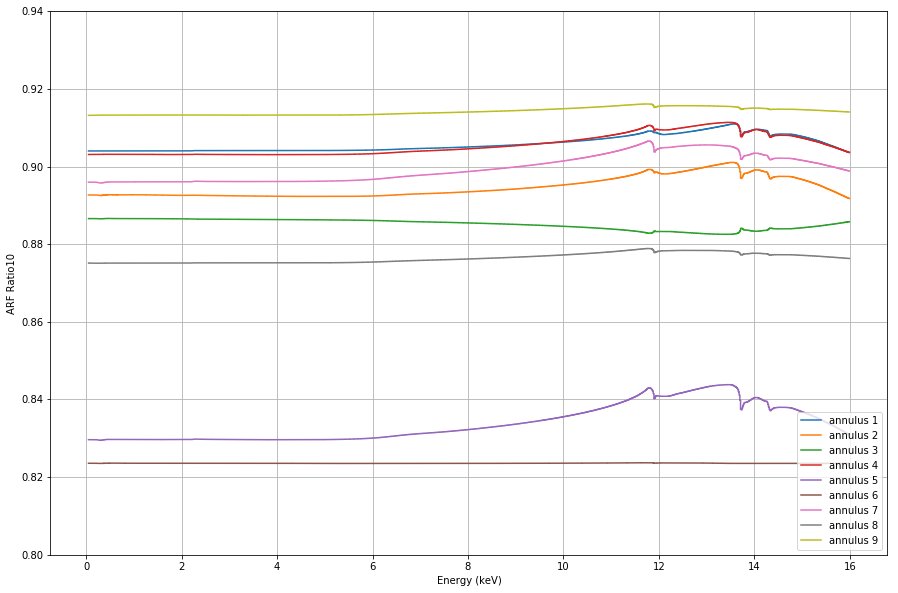

In [40]:
fig,ax = plt.subplots(figsize=(15,10))
#
for j in range(1,10):
    arfset0 = f'{target}_{obsid}_{inst}_test0_ann{j}.arf'
    arfset1 = f'{target}_{obsid}_{inst}_test1_ann{j}.arf'
    hdu0 = fits.open(arfset0)
    hdu1 = fits.open(arfset1)
    #
    x0 = hdu0['SPECRESP'].data["ENERG_LO"]
    y0 = hdu0['SPECRESP'].data["SPECRESP"]
    #
    x1 = hdu1['SPECRESP'].data["ENERG_LO"]
    y1 = hdu1['SPECRESP'].data["SPECRESP"]
    #
    ratio10 = y1/y0
    #
    ax.plot(x0,ratio10,drawstyle='steps',label=f'annulus {j}')
ax.set_ylim((0.8,0.94))
ax.set_title("ARF ratios in annuli using  XMM-SAS v18.0.0")
ax.set_xlabel("Energy (keV)")
ax.set_ylabel("ARF Ratio10")
ax.grid()
ax.legend();
    

Compare with SAS 16.1.0, needs that the ARF files for test0 and test1 are available in each annulus.

Ring 1, ratio in SAS 18: 0.904, SAS 16.1: 0.902, diff=0.002
Ring 2, ratio in SAS 18: 0.893, SAS 16.1: 0.904, diff=-0.011
Ring 3, ratio in SAS 18: 0.887, SAS 16.1: 0.878, diff=0.008
Ring 4, ratio in SAS 18: 0.903, SAS 16.1: 0.896, diff=0.007
Ring 5, ratio in SAS 18: 0.830, SAS 16.1: 0.828, diff=0.002
Ring 6, ratio in SAS 18: 0.824, SAS 16.1: 0.817, diff=0.006
Ring 7, ratio in SAS 18: 0.896, SAS 16.1: 0.888, diff=0.008
Ring 8, ratio in SAS 18: 0.875, SAS 16.1: 0.870, diff=0.005
Ring 9, ratio in SAS 18: 0.913, SAS 16.1: 0.909, diff=0.004


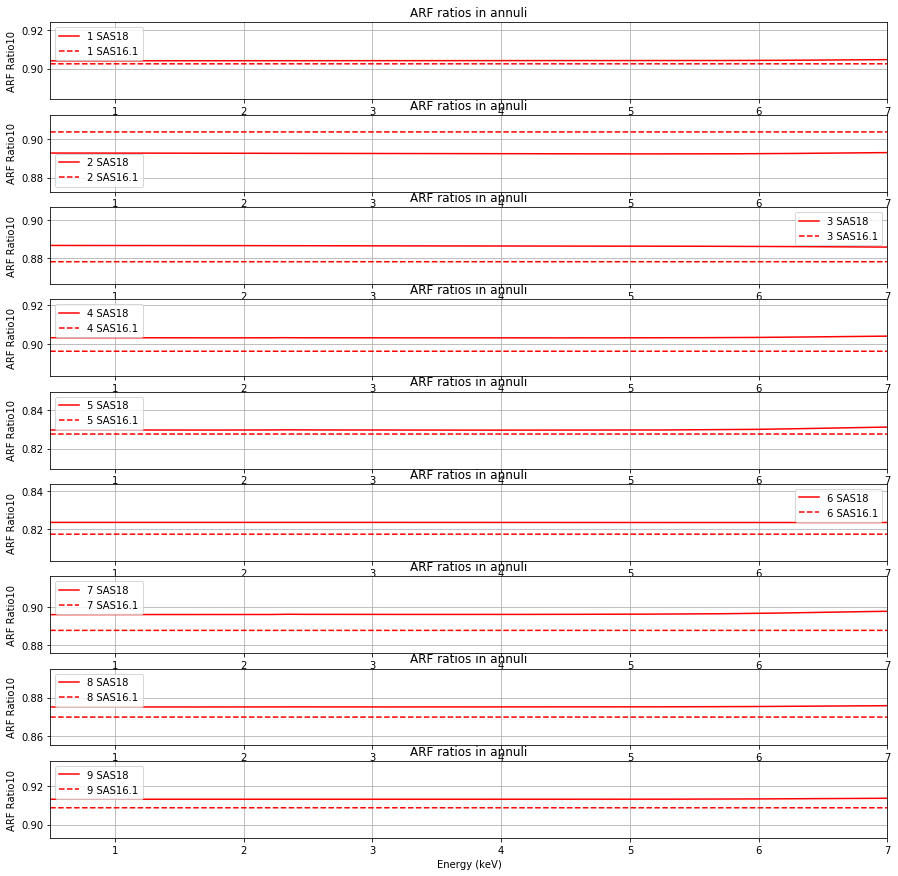

In [71]:
fig,axs = plt.subplots(9,1,figsize=(15,15))
for j in range(1,10):
    arfset0a = f'{target}_{obsid}_{inst}_test0_ann{j}.arf'
    arfset1a = f'{target}_{obsid}_{inst}_test1_ann{j}.arf'
    arfset0b = f'../proc_161/{target}_{obsid}_{inst}_test0_ann{j}.arf'
    arfset1b = f'..//proc_161/{target}_{obsid}_{inst}_test1_ann{j}.arf'
    hdu0a = fits.open(arfset0a)
    hdu1a = fits.open(arfset1a)
    hdu0b = fits.open(arfset0b)
    hdu1b = fits.open(arfset1b)
    #
    x0a = hdu0a['SPECRESP'].data["ENERG_LO"]
    y0a = hdu0a['SPECRESP'].data["SPECRESP"]
    x0b = hdu0b['SPECRESP'].data["ENERG_LO"]
    y0b = hdu0b['SPECRESP'].data["SPECRESP"]
    #
    x1a = hdu1a['SPECRESP'].data["ENERG_LO"]
    y1a = hdu1a['SPECRESP'].data["SPECRESP"]
    x1b = hdu1b['SPECRESP'].data["ENERG_LO"]
    y1b = hdu1b['SPECRESP'].data["SPECRESP"]
    #
    ratio10a = y1a/y0a
    ma = np.mean(ratio10a[0:100])
    ratio10b = y1b/y0b
    mb = np.mean(ratio10b[0:100])
    print (f"Ring {j}, ratio in SAS 18: {ma:.3f}, SAS 16.1: {mb:.3f}, diff={ma-mb:.3f}")
    #
    p = axs[j-1].plot(x0a,ratio10a,color='red',label=f'{j} SAS18')
    axs[j-1].plot(x0b,ratio10b,linestyle='--',color='red',label=f'{j} SAS16.1')
    yqm = ratio10a[0]
    axs[j-1].set_xlim((0.5,7.0))
    axs[j-1].set_ylim((yqm-0.02,yqm+0.02))
    axs[j-1].set_title("ARF ratios in annuli")
    axs[j-1].set_xlabel("Energy (keV)")
    axs[j-1].set_ylabel("ARF Ratio10")
    axs[j-1].grid()
    axs[j-1].legend();
